# Traffic&nbsp;Sign&nbsp;Classification with a Deep Convolutional&nbsp;Neural&nbsp;Network
by Karl J. Obermeyer

For instructions on running this notebook, see README.md. For a prose-only project report, see report.html.

The deep CNN (Convolutional Neural Network) is implemented in TensorFlow.  The network architecture is based loosely on [LeNet-5](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf). Images used for training, validation, and testing are pre-cropped versions of the [GTSRB (German Traffic Sign Recognition Benchmark)](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) available [here](  https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip). Five independently obtained Creative Commons images are also examined as independent test cases.

In [1]:
#%qtconsole  # For inspecting variables.

In [2]:
# Standard
import os
from glob import glob  # Unix style pathname pattern expansion.
import csv
import pickle
import time

# Scientific Computing and Visualization
import numpy as np; np.random.seed(13)  # Lucky seed.
import matplotlib.pyplot as plt
%matplotlib inline
import cv2  # Image processing.

# Machine Learning
#from sklearn.utils import shuffle  # Used numpy's shuffle instead.
#from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.contrib.layers import flatten

# Project-Specific.
# Includes custom functions for
# image processing, data manipulation, and dataset visualization.
from image_recognition_tools import *

## 0&nbsp;&nbsp;&nbsp;Load Data

In [3]:
data_dirname = './data/gtsrb.precropped/'
filename_train = data_dirname + 'train.pkl'
filename_validate = data_dirname + 'validate.pkl'
filename_test = data_dirname + 'test.pkl'
filename_english_labels = data_dirname + 'english_names.csv'

with open(filename_train, mode='rb') as fin:
    train = pickle.load(fin)
with open(filename_validate, mode='rb') as fin:
    validate = pickle.load(fin)
with open(filename_test, mode='rb') as fin:
    test = pickle.load(fin)
with open(filename_english_labels, mode='rt') as fin:
    reader = csv.reader(fin, delimiter=',')
    next(reader)  # Skip header.
    english_labels = { int(item[0]): item[1] for item in reader }

X_train, y_train = shuffle(train['features'], train['labels'])
X_validate, y_validate = shuffle(validate['features'], validate['labels'])
X_test, y_test = shuffle(test['features'], test['labels'])

## 1&nbsp;&nbsp;&nbsp;Dataset Summary, Exploration, and&nbsp;Balancing

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. *THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES*.

### Sizes and Shapes

In [4]:
# Number of training examples.
training_example_cnt = X_train.shape[0]

# Number of validation examples.
validation_example_cnt = X_validate.shape[0]

# Number of testing examples.
test_example_cnt = X_test.shape[0]

# List of unique class labels.
class_list = list(set(y_train) | set(y_validate) | set(y_test))
class_list.sort()

# Number of classes in the dataset.
class_cnt = len(class_list)  # Should be 0,...,42
assert class_cnt == len(english_labels)

# Single image shape.
image_shape = X_train[0, :].shape

print('Number of training examples =', training_example_cnt)
print('Number of validation examples =', validation_example_cnt)
print('Number of testing examples =', test_example_cnt)
print('Number of classes =', class_cnt)
print('Image shape =', image_shape)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Number of classes = 43
Image shape = (32, 32, 3)


### Exploratory Visualization

To get an idea of what type of sign each class represents, we synthesize a summary image from all example images in each class (training, validation and testing images combined).  The summary image could be created in a variety of ways, e.g., by choosing one example, taking the pixelwise mean, or the pixelwise median.  We use the pixelwise median here.  In order to compute the median, we first make a dict, `images_by_label` which allows easy access to all images by label.  Keys of this dict are labels and each value is a large numpy array containing all images of the corresponding label.

In [5]:
X_all, y_all = combine(
    X_train, y_train, X_validate, y_validate, X_test, y_test)
images_by_label = sort_by_class(X_all, y_all, class_list)

And now we compute and display the medians, one for each label.

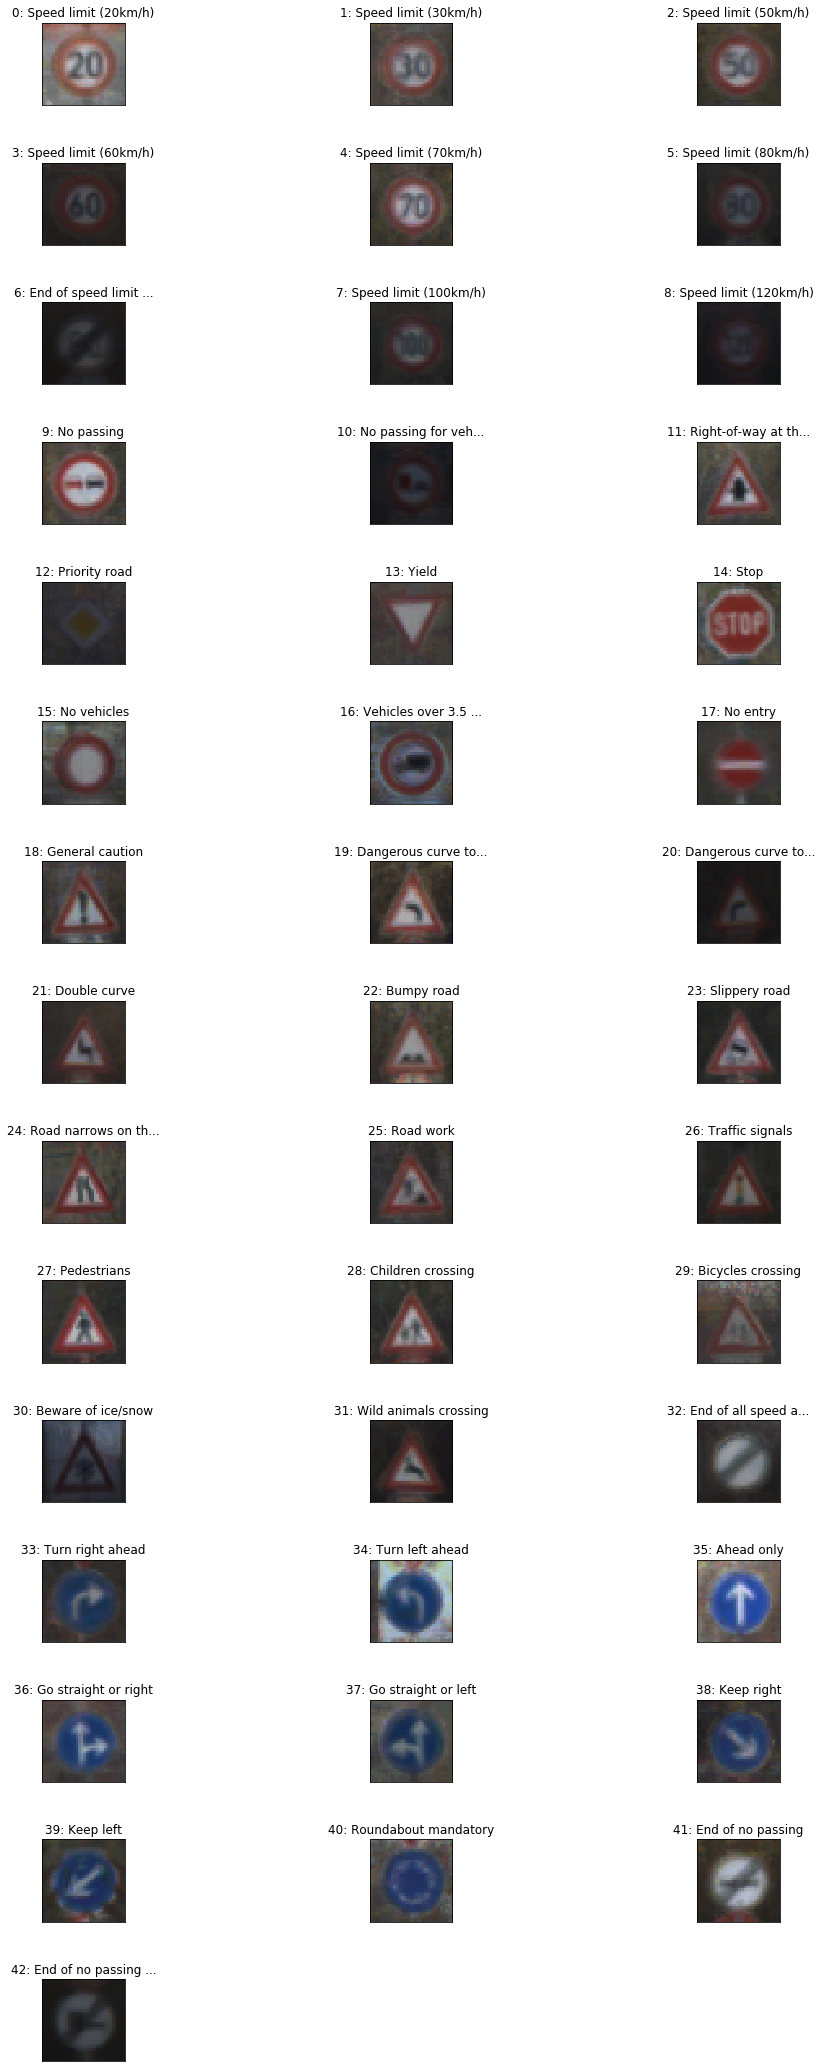

In [6]:
plot_representative_images(
    images_by_label, class_cnt=class_cnt, english_labels=english_labels,
    method='median', image_cnt=None)
#plt.savefig('./fig/class_representative_images.png')

Next, let's see how balanced the data are by making histograms of the labels in each of the different subsets of the data.

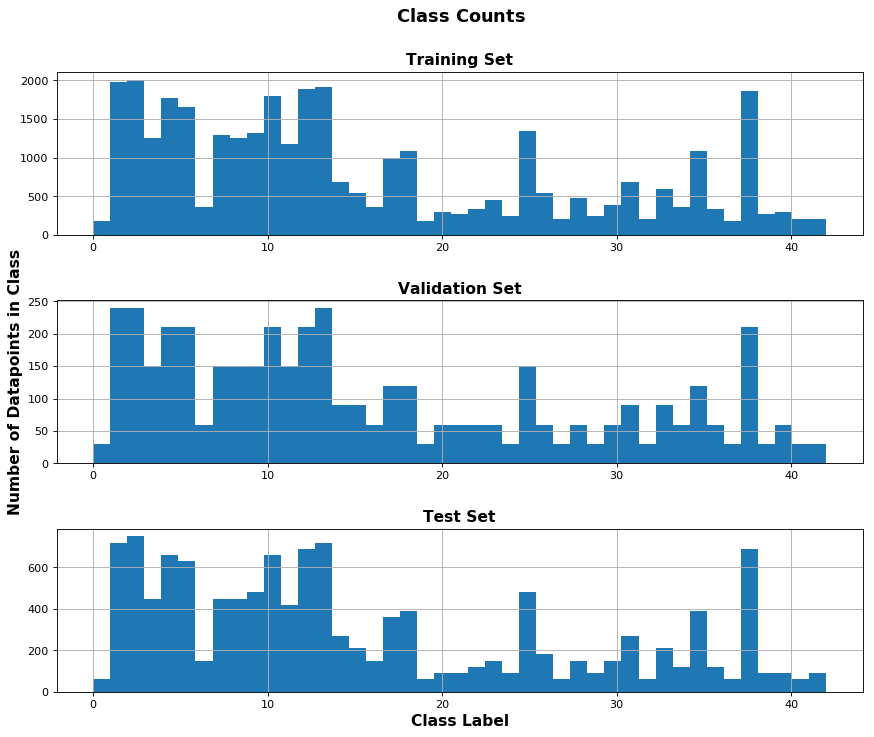

In [7]:
class_histograms(y_train, y_validate, y_test, class_cnt=class_cnt)
#plt.savefig('./fig/class_histograms.png')

Each class seems to have fairly equal representation across subsets (train, validate, test) of the data, but some classes have greater representation within each subset. We must be wary that training with unbalanced data can bias the final classifier away from under-represented classes. Therefore, we construct a more balanced dataset.

### Data Balancing

To create a more balanced dataset, we augment the data by stratified sampling together with random image perturbation.  Image perturbation is implemented in the `randomly_perturb` function in `image_recognition_tools.py`.  Images are perturbed by random changes in brightness, rotation, translation, and shear.  This helps train the CNN to classify images captured under a greater variety of conditions.

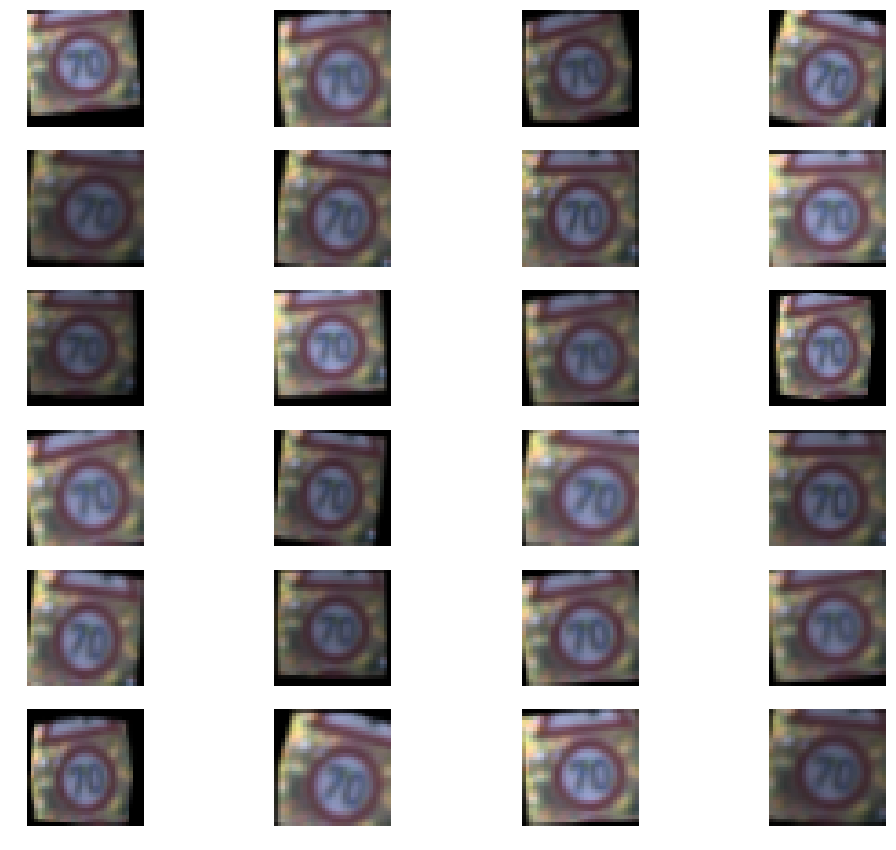

In [8]:
image = X_train[100, :]
test_randomly_perturb(
    image,
    brightness_radius=0.3,
    rotation_radius=30.0,
    translation_radius=3,
    shear_radius=3)
#plt.savefig('./fig/image_perturbations_example.png')

In [9]:
DATAPOINTS_PER_CLASS_FOR_TRAINING = 3000  # Default 3000.
X_train_balanced, y_train_balanced = balance(
    X_train, y_train, class_list,
    datapoint_cnt_per_class=DATAPOINTS_PER_CLASS_FOR_TRAINING,
    perturb=True)
    
X_validate_balanced, y_validate_balanced = balance(
    X_validate, y_validate, class_list, datapoint_cnt_per_class=None, perturb=True)
    
X_test_balanced, y_test_balanced = balance(
    X_test, y_test, class_list, datapoint_cnt_per_class=None, perturb=False)

In [10]:
print('Number of balanced training examples =', len(y_train_balanced))
print('Number of balanced validation examples =', len(y_validate_balanced))
print('Number of balanced testing examples =', len(y_test_balanced))

Number of balanced training examples = 129000
Number of balanced validation examples = 10320
Number of balanced testing examples = 32250


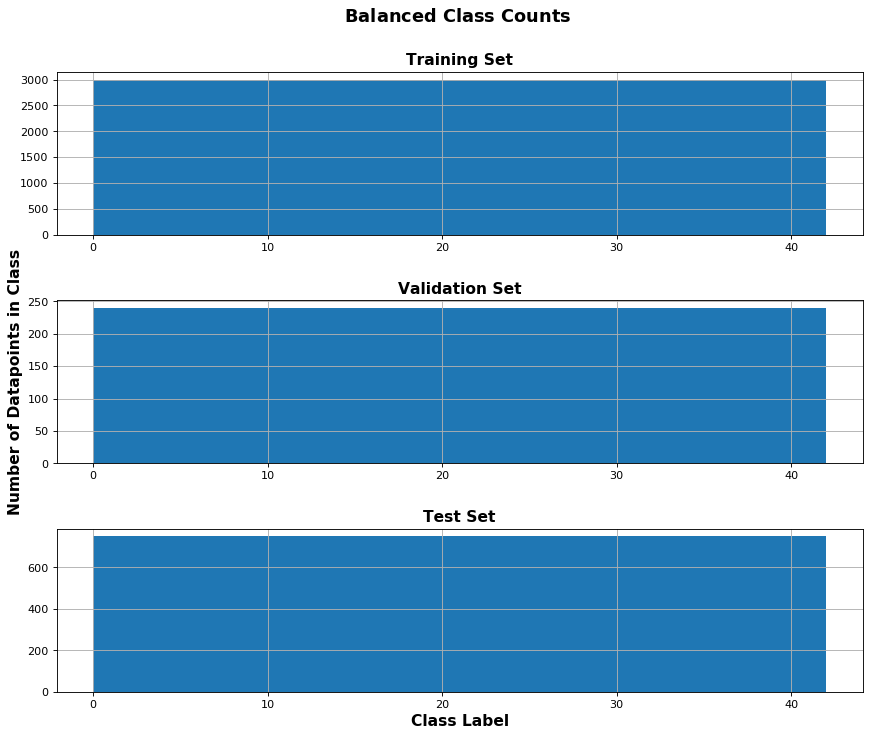

In [11]:
class_histograms(
    y_train_balanced,
    y_validate_balanced,
    y_test_balanced,
    class_cnt=class_cnt,
    suptitle_prefix='Balanced')
#plt.savefig('./fig/class_histograms-balanced.png')

## 2&nbsp;&nbsp;&nbsp;CNN Architecture&nbsp;and&nbsp;Testing

We use an architecture based on [LeNet-5](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf).  LeNet-5 had a 10-class output whereas we have 43 classes.  Modifying LeNet-5 only by increasing the number of output classes resulted in a 0.89 test accuracy. To improve performance, we increased the depth of the convolution filters, increased the size of the fully connected layers, and added dropout regularization as in the figure below. With these changes, we achieve a test accuracy of 0.958.

<img src="./fig/cnn_architecture-horizontal.png" alt="Drawing" style="width: 700px; margin: 0 auto"/>

### Image Preprocessing: Brightness Equalization, Grayscale, and&nbsp;Normalization.

Brightness equalization using the histogram technique, implemented in OpenCV, should help our CNN perform more consistantly accross varying lighting conditions.  Since shape and markings are much more important for sign classification than color, we help our CNN focus on what's most important by grayscaling images.  Finally, normalizing pixel values to the range [-1.0, 1.0] helps mitigate optimization problems that can be caused by scale differences between features learned by the CNN.

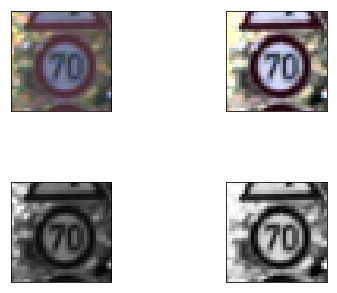

In [12]:
test_histogram_equalize_brightness(X_train[100, :])
#plt.savefig('./fig/histogram_brightness_equalization.png')

In [13]:
def preprocess(X):
    '''Prepare numpy array of images for input into CNN.
    
    Args:
        X: numpy array of images, e.g., as X_train,
          X_validate, or X_test.
    
    Returns:
        X_in: numpy array of histogram equalized, normalized, gray images.
    '''
    X_in = np.zeros((X.shape[0], X.shape[1], X.shape[2], 1), dtype=np.float32)
    
    for i, image in enumerate(X):
        image = histogram_equalize_brightness(image)
        image = rgb2gray(image)
        X_in[i, :] = normalize(image)[:, :, None]  # Adds degenerate dimension.
    
    return X_in

We use `_in` to denote preprocessed versions of data because it is what is feed *in*to the neural network proper.

In [14]:
X_train_balanced_in = preprocess(X_train_balanced)

In [15]:
X_train_in, y_train = X_train_balanced_in, y_train_balanced

In [16]:
X_validate_balanced_in = preprocess(X_validate_balanced)
X_validate_in = preprocess(X_validate)

In [17]:
X_test_balanced_in = preprocess(X_test_balanced)
X_test_in = preprocess(X_test)

### TensorFlow Graph Definition

In [18]:
def kjo_net(X_in, keep_probability):
    '''CNN Architecture.
    
    Args:
        X_in: tf.placeholder(tf.float32, (None, 32, 32, 1)), preprocessed images.
        keep_probability: tf.placeholder(tf.float32), probability of keeping nodes
            during dropout.
    
    Returns:
        logits
    '''
    # Hyperparameters used with tf.truncated_normal to set random
    # initial values of the weights and biases in each layer.
    mu = 0.0  # Default 0.0
    sigma = 0.1  # Default 0.1
    #
    # If using ReLU activations, initialize with slight positive bias, e.g., 0.1,
    # to avoid "dead neurons". 
    initial_bias = 0.05
    
    
    # Layer 1: Convolutional, 32x32x1 --> 28x28x16.
    # In nominal LeNet was 32x32x1 --> 28x28x6.
    # shape := (
    #   filter_height,
    #   filter_width,
    #   input_depth aka input_channel_cnt,
    #   output_depth aka output_channel_cnt).
    conv1_W = tf.Variable(
        tf.truncated_normal(shape=(5, 5, 1, 16), mean=mu, stddev=sigma),
        name='conv1_W')
    conv1_b = tf.Variable(tf.zeros(16) + initial_bias, name='conv1_b')
    conv1 = tf.nn.conv2d(
        X_in, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)  # Activation.
    #
    # Pooling. 28x28x16 --> 14x14x16.
    # In nominal LeNet was 28x28x6 --> 14x14x6.
    conv1 = tf.nn.max_pool(
        conv1, ksize=[1, 2, 2, 1],
        strides=[1, 2, 2, 1], padding='VALID')

    
    # Layer 2: Convolutional, 14x14x16 --> 10x10x32.
    # In nominal LeNet was 14x14x6 --> 10x10x16.
    conv2_W = tf.Variable(
        tf.truncated_normal(shape=(5, 5, 16, 32), mean=mu, stddev=sigma),
        name='conv2_W')
    conv2_b = tf.Variable(tf.zeros(32) + initial_bias, name='conv2_b')
    conv2 = tf.nn.conv2d(
        conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)  # Activation.
    #
    # Pooling, 10x10x32 --> 5x5x32.
    # In nominal LeNet was 10x10x16 --> 5x5x16.
    conv2 = tf.nn.max_pool(
        conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    
    # Flatten layer, 5x5x32 --> 800.
    # In nominal LeNet was 5x5x16 --> 400.
    # Flattens tensor into 2 dimensions (batches, length).
    fc0 = flatten(conv2)
    
    
    # Layer 3: Fully Connected, 800 --> 600.
    # In nominal LeNet was 400 --> 120.
    fc1_W = tf.Variable(
        tf.truncated_normal(shape=(800, 600), mean=mu, stddev=sigma),
        name='fc1_W')
    fc1_b = tf.Variable(tf.zeros(600) + initial_bias, name='fc1_b')
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)  # Activation.
    #
    # Dropout. 
    fc1 = tf.nn.dropout(fc1, keep_probability)
    
    
    # Layer 4: Fully Connected, 600 --> 500.
    # In nominal LeNet was 120 --> 84.
    fc2_W = tf.Variable(
        tf.truncated_normal(shape=(600, 500), mean=mu, stddev=sigma),
        name='fc2_W')
    fc2_b = tf.Variable(tf.zeros(500) + initial_bias, name='fc2_b')
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    fc2 = tf.nn.relu(fc2)  # Activation.
    # Dropout. 
    fc2 = tf.nn.dropout(fc2, keep_probability)
    
    
    # Layer 5: Fully Connected, 500 --> class_cnt (default 43).
    # In nominal LeNet was 84 --> 10.
    fc3_W = tf.Variable(
        tf.truncated_normal(shape=(500, class_cnt), mean=mu, stddev=sigma),
        name='fc3_W')
    fc3_b = tf.Variable(tf.zeros(class_cnt) + initial_bias, name='fc3_b')
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    
    return logits

### Training and Validation

The code in this section was used to perform validation runs to determine a good `KEEP_PROBABILITY` value for dropout regularization.  Of the validated values, 0.4 was the best and was used for final testing.  Note: output from validation sessions has been omitted as it was extremely long.  Only the output of the final training session is included in the next section.

In [19]:
# Hyperparameters.
LEARNING_RATE = 0.001 # Default 0.001
EPOCH_CNT = 30  # Number of times to run over training data. Default 30.
BATCH_SIZE = 256  # Datapoints to consider per backprop pass. Default 256.
KEEP_PROBABILITY = 0.4 # For dropout regularization.  Try 0.5, 0.6, 0.7, 1.0

In [20]:
# Input images and output labels.
X_in = tf.placeholder(tf.float32, (None, 32, 32, 1))  # None => arbitrary batch size.
y = tf.placeholder(tf.int32, (None))  # None => arbitrary batch size.
keep_probability = tf.placeholder(tf.float32)
y_one_hot = tf.one_hot(y, class_cnt)
#keep_probability = tf.placeholder(tf.float32)

In [21]:
logits = kjo_net(X_in, keep_probability)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=y_one_hot, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_one_hot, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [22]:
# To save parameters for re-use.
saver = tf.train.Saver()  # Must be initialized after tf symbolic variables.
validation_save_filename = './kjo_net.validation.ckpt'

In [23]:
def compute_accuracy(session, X_in_, y_):
    '''Compute model accuracy.
    
    ::WARNING:: The trailing underscores on the argument variable names
    are to prevent collision with global tensoflow variables X_in and y.
    
    Args:
        session: tf.session.
        X_in_: np.array, preprocessed inputs.
        y_: np.array, outputs corresponding to X_in.
        
    Returns:
        float, accuracy of model applied to (X_in, y).
    '''
    
    #session = tf.get_default_session()
    example_cnt = len(X_in_)
    total_accuracy = 0
    for offset in range(0, example_cnt, BATCH_SIZE):
        batch_X_in, batch_y = \
            X_in_[offset:offset+BATCH_SIZE], \
            y_[offset:offset+BATCH_SIZE]
        accuracy = session.run(
            accuracy_operation,
            feed_dict={X_in: batch_X_in, y: batch_y, keep_probability: 1.0})
        total_accuracy += (accuracy * len(batch_X_in))
        
    return total_accuracy / example_cnt

In [24]:
start_time = time.time()
accuracies_train = []
accuracies_validate = []
accuracies_validate_balanced = []

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    example_cnt = len(X_train_in)
    print('Training...\n')
    for i in range(EPOCH_CNT):
        
        X_train_in, y_train = shuffle(X_train_in, y_train)
        for offset in range(0, example_cnt, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_X_in, batch_y = X_train_in[offset:end], y_train[offset:end]
            session.run(
                training_operation,
                feed_dict={X_in: batch_X_in, y: batch_y, keep_probability: KEEP_PROBABILITY})
            
        accuracy_train = compute_accuracy(session, X_train_in, y_train)
        accuracies_train.append(accuracy_train)
        
        accuracy_validate = compute_accuracy(session, X_validate_in, y_validate)
        accuracies_validate.append(accuracy_validate)

        accuracy_validate_balanced = compute_accuracy(session, 
            X_validate_balanced_in, y_validate_balanced)
        accuracies_validate_balanced.append(accuracy_validate_balanced)
        
        print('EPOCH {} ...'.format(i+1))
        #print("Loss = {:.3f}".format(loss))
        print('Training Accuracy = {:.3f}'.format(accuracy_train))
        print('Validation Accuracy = {:.3f}'.format(accuracy_validate))
        print('Balanced Validation Accuracy = {:.3f}'.format(
            accuracy_validate_balanced))
        print()
        
    saver.save(session, validation_save_filename)
    print("Model saved")

dt_s = time.time() - start_time
dt_m = dt_s / 60.0
dt_h = dt_s / 3600.0
print('Wallclock time elapsed:' \
    ' {:.3f} s = {:.3f} m = {:.3f} h.'.format(dt_s, dt_m, dt_h))

Training...

EPOCH 1 ...
Training Accuracy = 0.852
Validation Accuracy = 0.860
Balanced Validation Accuracy = 0.779

EPOCH 2 ...
Training Accuracy = 0.947
Validation Accuracy = 0.935
Balanced Validation Accuracy = 0.883

EPOCH 3 ...
Training Accuracy = 0.970
Validation Accuracy = 0.962
Balanced Validation Accuracy = 0.917

EPOCH 4 ...
Training Accuracy = 0.981
Validation Accuracy = 0.972
Balanced Validation Accuracy = 0.935

EPOCH 5 ...
Training Accuracy = 0.984
Validation Accuracy = 0.973
Balanced Validation Accuracy = 0.940

EPOCH 6 ...
Training Accuracy = 0.990
Validation Accuracy = 0.976
Balanced Validation Accuracy = 0.943

EPOCH 7 ...
Training Accuracy = 0.993
Validation Accuracy = 0.977
Balanced Validation Accuracy = 0.952

EPOCH 8 ...
Training Accuracy = 0.995
Validation Accuracy = 0.983
Balanced Validation Accuracy = 0.955

EPOCH 9 ...
Training Accuracy = 0.993
Validation Accuracy = 0.976
Balanced Validation Accuracy = 0.947

EPOCH 10 ...
Training Accuracy = 0.996
Validation A

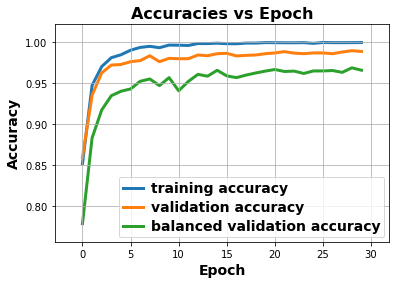

In [25]:
# Plot accuracies vs epoch.
plt.plot(
    np.arange(EPOCH_CNT), accuracies_train,
    label='training accuracy', zorder=0, linewidth=3)
plt.plot(
    np.arange(EPOCH_CNT), accuracies_validate,
    label='validation accuracy', zorder=0, linewidth=3)
plt.plot(
    np.arange(EPOCH_CNT), accuracies_validate_balanced,
    label='balanced validation accuracy', zorder=0, linewidth=3)
plt.title('Accuracies vs Epoch', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
legend = plt.legend(numpoints=1)
plt.setp(legend.get_texts(), fontsize='14', fontweight='bold')
ax = plt.gca()
#plt.axis('equal') # Defective so use set_aspect instead?
#ax.set_aspect('equal', adjustable='box')
ax.margins(0.1)
#ax.set_yscale('log')
#ax.autoscale(tight=True)
#plt.xlim((0, 2000.0))
#plt.ylim((0, 1000.0))
plt.grid(True)
plt.show()
#plt.savefig('./fig/accuracies_vs_epoch.png')

In [26]:
with tf.Session() as session:
    #saver = tf.train.import_meta_graph('kjo_net.meta')
    #saver.restore(session, tf.train.latest_checkpoint('.'))
    saver.restore(session, validation_save_filename)
    test_accuracy = compute_accuracy(session, X_test_in, y_test)
    test_accuracy_balanced = compute_accuracy(session, X_test_balanced_in, y_test_balanced)
    print('Test Accuracy = {:.3f}'.format(test_accuracy))
    print('Balanced Test Accuracy = {:.3f}'.format(test_accuracy_balanced))    

Test Accuracy = 0.961
Balanced Test Accuracy = 0.949


### Final Training and Testing

In this section we add the balanced validation set to the balanced training set and re-train to get the final network parameters. This should only be done for the final training, i.e., after architecture and hyperparameters have been fixed based on validation performance. If you do not wait to combine training and validation sets until the final training, then you are data snooping!

In [27]:
X_train_final_in, y_train_final = combine(
    X_train_balanced_in, y_train_balanced, X_validate_balanced_in, y_validate_balanced)
print('Number of datapoints in final training set:', len(y_train_final)) 

Number of datapoints in final training set: 139320


In [28]:
# To save parameters for re-use.
testing_save_filename = './kjo_net.testing.ckpt'

In [29]:
start_time = time.time()
accuracies_train = []
accuracies_test = []
accuracies_test_balanced = []

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    example_cnt = len(X_train_final_in)
    print('Training...\n')
    for i in range(EPOCH_CNT):
        
        X_train_final_in, y_train_final = shuffle(X_train_final_in, y_train_final)
        for offset in range(0, example_cnt, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_X_in, batch_y = X_train_final_in[offset:end], y_train_final[offset:end]
            session.run(
                training_operation,
                feed_dict={X_in: batch_X_in, y: batch_y, keep_probability: KEEP_PROBABILITY})
            
        accuracy_train = compute_accuracy(session, X_train_final_in, y_train_final)
        accuracies_train.append(accuracy_train)
        
        accuracy_test = compute_accuracy(session, X_test_in, y_test)
        accuracies_test.append(accuracy_test)

        accuracy_test_balanced = compute_accuracy(session, X_test_balanced_in, y_test_balanced)
        accuracies_test_balanced.append(accuracy_test_balanced)
        
        print('EPOCH {} ...'.format(i+1))
        #print("Loss = {:.3f}".format(loss))
        print('Training Accuracy = {:.3f}'.format(accuracy_train))
        print('Test Accuracy = {:.3f}'.format(accuracy_test))
        print('Balanced Test Accuracy = {:.3f}'.format(
            accuracy_test_balanced))
        print()
        
    saver.save(session, testing_save_filename)
    print("Model saved")

dt_s = time.time() - start_time
dt_m = dt_s / 60.0
dt_h = dt_s / 3600.0
print('Wallclock time elapsed:' \
    ' {:.3f} s = {:.3f} m = {:.3f} h.'.format(dt_s, dt_m, dt_h))

Training...

EPOCH 1 ...
Training Accuracy = 0.855
Test Accuracy = 0.844
Balanced Test Accuracy = 0.839

EPOCH 2 ...
Training Accuracy = 0.939
Test Accuracy = 0.911
Balanced Test Accuracy = 0.910

EPOCH 3 ...
Training Accuracy = 0.962
Test Accuracy = 0.924
Balanced Test Accuracy = 0.918

EPOCH 4 ...
Training Accuracy = 0.976
Test Accuracy = 0.935
Balanced Test Accuracy = 0.929

EPOCH 5 ...
Training Accuracy = 0.986
Test Accuracy = 0.943
Balanced Test Accuracy = 0.932

EPOCH 6 ...
Training Accuracy = 0.988
Test Accuracy = 0.943
Balanced Test Accuracy = 0.928

EPOCH 7 ...
Training Accuracy = 0.992
Test Accuracy = 0.947
Balanced Test Accuracy = 0.944

EPOCH 8 ...
Training Accuracy = 0.995
Test Accuracy = 0.949
Balanced Test Accuracy = 0.946

EPOCH 9 ...
Training Accuracy = 0.995
Test Accuracy = 0.953
Balanced Test Accuracy = 0.946

EPOCH 10 ...
Training Accuracy = 0.996
Test Accuracy = 0.946
Balanced Test Accuracy = 0.939

EPOCH 11 ...
Training Accuracy = 0.996
Test Accuracy = 0.953
Balan

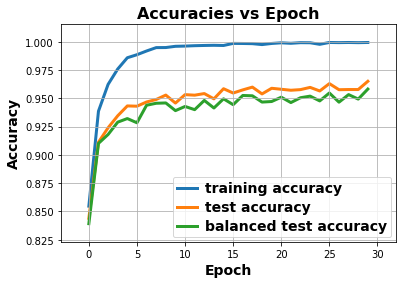

In [30]:
# Plot accuracies vs epoch.
plt.plot(
    np.arange(EPOCH_CNT), accuracies_train,
    label='training accuracy', zorder=0, linewidth=3)
plt.plot(
    np.arange(EPOCH_CNT), accuracies_test,
    label='test accuracy', zorder=0, linewidth=3)
plt.plot(
    np.arange(EPOCH_CNT), accuracies_test_balanced,
    label='balanced test accuracy', zorder=0, linewidth=3)
plt.title('Accuracies vs Epoch', fontsize=16, fontweight='bold')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
legend = plt.legend(numpoints=1)
plt.setp(legend.get_texts(), fontsize='14', fontweight='bold')
ax = plt.gca()
#plt.axis('equal') # Defective so use set_aspect instead?
#ax.set_aspect('equal', adjustable='box')
ax.margins(0.1)
#ax.set_yscale('log')
#ax.autoscale(tight=True)
#plt.xlim((0, 2000.0))
#plt.ylim((0, 1000.0))
plt.grid(True)
#plt.savefig('./fig/accuracies_vs_epoch-final.png')

Since the gap between training and test accuracy is relatively small, and the accuracies increased roughly monotonically during training, I believe the model is well-fitting (i.e. not over- or underfitting).

## 3&nbsp;&nbsp;&nbsp;Testing on New Images

We now examine our classifier's performance on 5 independently obtained Creative Commons images.

### Load and Plot Images

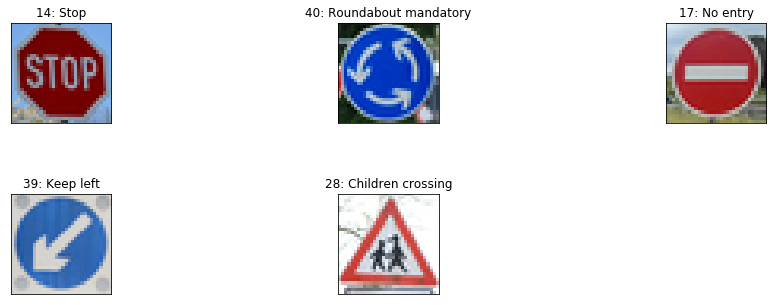

In [31]:
# Load new images.
new_datapoint_cnt = 5
X_new = np.zeros((new_datapoint_cnt, *image_shape), dtype=np.uint8)
y_new = np.zeros(new_datapoint_cnt, dtype=np.uint8)
new_image_glob_pattern = \
    './data/creative_commons.new_traffic_signs/' \
    '*.jpg'
ix_new_image = 0
for filename_with_relative_path in glob(new_image_glob_pattern):
    filename = os.path.basename(filename_with_relative_path)
    image_bgr = cv2.imread(filename_with_relative_path)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_rgb_resized = cv2.resize(image_rgb, (32,32))
    X_new[ix_new_image, :] = image_rgb_resized
    y_new[ix_new_image] = int(filename[:2])
    ix_new_image += 1

# Plot new images.
plot_images(X_new, y_new, english_labels)
plt.savefig('./fig/new_images.png')

### Predictions and Top 5 Softmax Probabilities for Each Image


Image 0
  Truth class 14: Stop
  Predicted class 14: Stop


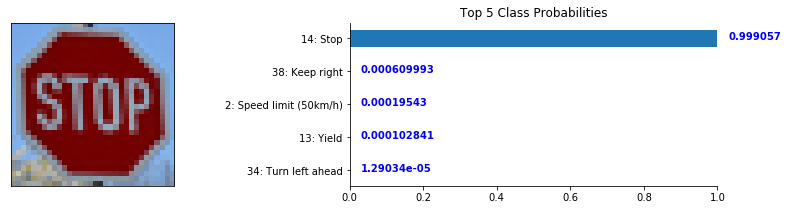


Image 1
  Truth class 40: Roundabout mandatory
  Predicted class 40: Roundabout mandatory


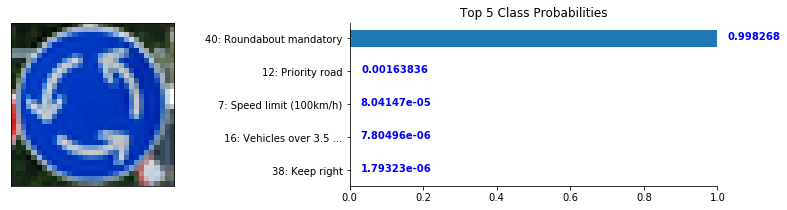


Image 2
  Truth class 17: No entry
  Predicted class 17: No entry


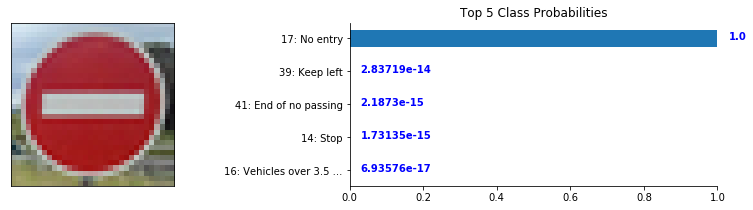


Image 3
  Truth class 39: Keep left
  Predicted class 39: Keep left


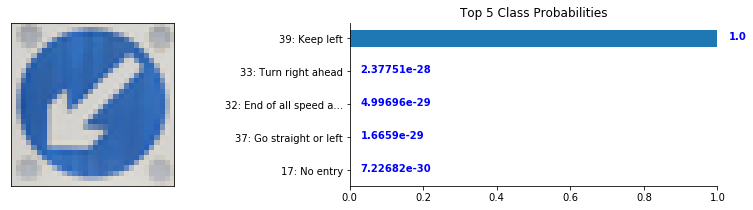


Image 4
  Truth class 28: Children crossing
  Predicted class 11: Right-of-way at the next intersection


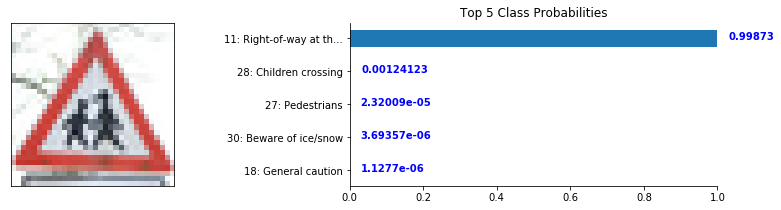

Test Accuracy on new images = 0.800


In [32]:
X_new_in = preprocess(X_new)

with tf.Session() as session:
    #session.run(tf.global_variables_initializer())
    #saver = tf.train.import_meta_graph('kjo_net.meta')
    #saver.restore(session, tf.train.latest_checkpoint('.'))
    saver.restore(session, testing_save_filename)
    top_k = session.run(
        tf.nn.top_k(tf.nn.softmax(logits), k=5),
        feed_dict={X_in: X_new_in, keep_probability: 1.0})
    test_accuracy = compute_accuracy(session, X_new_in, y_new)
    
# Plot softmax probabilities.
ixs = np.arange(X_new.shape[0])
probabilities, classes = top_k
probability_barh_width = 14.5
probability_barh_height = 3
for i, image in enumerate(X_new):
    
    print('\nImage %g\n  Truth class %g: %s\n  Predicted class %g: %s' % \
      (i, y_new[i], english_labels[y_new[i]], top_k[1][i, 0], english_labels[top_k[1][i, 0]]))

    fig, axes = plt.subplots(
        1, 2, figsize=(probability_barh_width, probability_barh_height))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.subplot(1, 2, 2)
    ax = plt.gca()
    plt.barh(ixs, probabilities[i], height=0.5, align='center')
    y_tick_labels = []    
    for j in ixs: 
        label = str(classes[i][j]) + ': ' + \
           english_labels[classes[i][j]]
        y_tick_labels.append(truncate_string(label, ubnd=25))
    plt.yticks( ixs, y_tick_labels)
    plt.title('Top 5 Class Probabilities')
    #plt.xlabel('Probability')
    #ax = plt.gca(); ax.set_xscale('log') 
    ax.invert_yaxis()
    for i, value in enumerate(probabilities[i]):
        ax.text(value + 0.03, i + .03, str(value), color='blue', fontweight='bold')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xlim(0.0, 1.0)
    
    plt.show();
    #plt.savefig('./fig/new_image-%03g.top_softmax_probabilities.png' % i)
    
print('Test Accuracy on new images = {:.3f}'.format(test_accuracy))       

### Performance Analysis

For the 5 new images, the final classifier performed perfectly. However, plots of the top 5 softmax probabilities reveal that there was a small amount of uncertainty in at least 2 of the classifications. As one would expect, the classes assigned the highest probabilities in each case correspond to traffic signs that look similar even to humans.

## 6&nbsp;&nbsp;&nbsp;Conclusions

In this project, I showed a successful TensorFlow implementation of a deep CNN (Convolutional Neural Network) for classifying traffic sign images based on the German Traffic Sign Dataset.  The architecture was chosen by scaling up LeNet-5 [1] and adding dropout regularization. This achieved 96.5% classification accuracy on the GTSRB test set, 95.8%  accuracy on a balanced version of the GTSRB test set, and 80.0% classification accuracy on five independently obtained images. Examining the top few softmax probabilities for the independently obtained images showed that the CNN did have some uncertainty in distinguishing between signs that were geometrically similar and look similar even to humans in grayscale.

### Limitations, Weaknesses, and Future Work

While 96.5% accuracy is a significant improvement over the 89.0% accuracy of the baseline CNN, there is still work to be done if the classifier is to be used in  real-time safety critical scenarios. For the next version of the CNN, I would consider the following modifications.

 * Change the input images to include all RGB colors, grayscale, and/or possibly even precomputed Canny edges.  

 * Try topologically different architectures, e.g., feed-forward from the first convolution to the first fully connected layer.

 * Gather more data and/or use more sophisticated data augmentation.

## References

[0] J. Stallkamp and M. Schlipsing and J. Salmen and C. Igel, [The German Traffic Sign Recognition Benchmark: A multi-class classification competition](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset), IEEE International Joint Conference on Neural Networks, 2011, p. 1453-1460.

[1] Y. LeCun and L. Bottou and Y. Bengio and P. Haffner, [Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf), Proceedings of the IEEE, 86(11):2278-2324, November 1998. Note: Lenet-5.

[2] G. E Hinton and N. Srivastava and A. Krizhevsky and I. Sutskever and R. R. Salakhutdinov, "Improving neural networks by preventing co-adaptation of feature detectors", ArXiv preprint, [https://arxiv.org/abs/1207.0580](https://arxiv.org/abs/1207.0580). Note: Dropout.

[3] P. Sermanet and Y. LeCun, [Traffic Sign Recognition with Multi-Scale Convolutional Networks](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf), 2011.